# Comparing Rabi Frequencies

This brief example will calculate the absorption of a weak probe in a vapor of Cs pumped by a stronger pump beam. 
Both are tuned to the D1 line for a specific polarization that is specified below. We want to compare the results for different values of the Rabi frequency of the pump beam. 

## Julia Environment
First we must set up the Julia environment. In particular, we must download the OpticalBlochEquations package from GitHub and add it to our environment. We can run the built-in tests, if we wish. After that, we will add a number of other packages that we will need to display the data.

In [1]:
using Pkg
Pkg.activate("myEnvironment")

  Activating project at `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment`


In [2]:
ENV["JULIA_SSL_CA_ROOTS_PATH"]=""

""

In [3]:
Pkg.add(url="https://github.com/floriansLU/OpticalBlochEquations.jl")

    Updating git-repo `https://github.com/floriansLU/OpticalBlochEquations.jl`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`


In [4]:
Pkg.test("OpticalBlochEquations")

     Testing OpticalBlochEquations
      Status `C:\Users\User\AppData\Local\Temp\jl_RkBtQQ\Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [8bb1440f] DelimitedFiles v1.9.1
  [057dd010] FastTransforms v0.17.0
  [2604418b] OpticalBlochEquations v1.1.0-DEV `https://github.com/floriansLU/OpticalBlochEquations.jl#master`
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.40.9
  [6e0679c1] QuantumOptics v1.2.2
  [295af30f] Revise v3.7.2
  [87c4ff3e] WignerD v0.1.4
  [9f57e263] WignerSymbols v2.0.0
  [8ba89e20] Distributed v1.11.0
  [37e2e46d] LinearAlgebra v1.11.0
  [2f01184e] SparseArrays v1.11.0
  [8dfed614] Test v1.11.0
      Status `C:\Users\User\AppData\Local\Temp\jl_RkBtQQ\Manifest.toml`
  [47edcb42] ADTypes v1.13.0
  [621f4979] AbstractFFTs v1.5.0
  [7d9f7c33] Accessors v0.1.41
  [79e6a3ab] Adapt v4.2.0
  [66dad0bd] AliasTables v1.1.3
  [ec485272] ArnoldiMethod v0.4.0
⌅ [7d9fca2a] Arpack v0.5.3
  [4fba245c] ArrayInterface v7.18.0
  [4c555306] ArrayLayouts v1.11.1
  [aae01518] B

   9577.9 ms  ✓ OrdinaryDiffEqStabilizedIRK
   9690.2 ms  ✓ OrdinaryDiffEqIMEXMultistep
   6731.4 ms  ✓ Plots → UnitfulExt
  10926.3 ms  ✓ OrdinaryDiffEqPDIRK
  12381.6 ms  ✓ OrdinaryDiffEqSDIRK
  14235.6 ms  ✓ StochasticDiffEq
   5667.9 ms  ✓ OrdinaryDiffEqExponentialRK
  16346.1 ms  ✓ OrdinaryDiffEqBDF
  29375.8 ms  ✓ OrdinaryDiffEqFIRK
  24757.2 ms  ✓ OrdinaryDiffEqDefault
   4842.1 ms  ✓ OrdinaryDiffEq
   5795.3 ms  ✓ QuantumOptics
  10307.0 ms  ✓ OpticalBlochEquations
  135 dependencies successfully precompiled in 266 seconds. 367 already precompiled.
  1 dependency had output during precompilation:
┌ QuantumOpticsBase
│  WARNING: Wrapping `Vararg` directly in UnionAll is deprecated (wrap the tuple instead).
│  You may need to write `f(x::Vararg{T})` rather than `f(x::Vararg{<:T})` or `f(x::Vararg{T}) where T` instead of `f(x::Vararg{T} where T)`.
│  WARNING: Wrapping `Vararg` directly in UnionAll is deprecated (wrap the tuple instead).
│  You may need to write `f(x::Vararg{T})` r

In [5]:
Pkg.add("BenchmarkTools");
Pkg.add("Plots");
Pkg.add("PlotlyBase");
Pkg.add("PlotlyKaleido");
Pkg.add("Profile")
Pkg.add("DataFrames")
Pkg.add("CSV")
using Distributed;
addprocs(Sys.CPU_THREADS);
using BenchmarkTools;
using OpticalBlochEquations
using DataFrames
using CSV
using Plots
plotly()

   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to

Plots.PlotlyBackend()

## Defining the parameters
Now we set up the calculation. The function `param(cesiumD1)` defines the quantum numbers of the ground and excited states of the Cesium D1 line and create a structure that contain all the necessary operators. The function laser creates a structure for the Rabi frequency, natural line width, transit relaxation, laser frequency, laser linewidth, temperature, atomic mass, and other constants.  

The interation of the atomic dipole with the electric field of the light is given by: 

$\hat{V}=-\hat{\mathbf{d}}\cdot\hat{\mathbf{E}}(t)$

The electric field is given by

$\hat{\mathbf{E}}(t)=\varepsilon(t)\mathbf{\epsilon} + \varepsilon^{*}(t)\mathbf{\epsilon^{*}}$

where $\epsilon$ is the polarization vector and 

$\varepsilon(t)=| \varepsilon_{\overline{\omega}}|e^{i\Phi(t)-i(\overline{\omega}-\mathbf{k}_{\overline{\omega}}\cdot \mathbf{v})t}$,

where $\varepsilon_{\overline{\omega}}$ is the amplitude,$\Phi(t)$ is a, possibly, time-dependent phase, $\overline{\omega}$ is the frequency of the light, $\mathbf{k}_{\overline{\omega}}$ is the wave vector of the light, and $\mathbf{v}$ is the velocity of the atom that interacts with the light.    

The polarization is defined using spherical polarization vectors. The spherical polarization vectors correspond to light that is left-circularly polarized ($\epsilon^{+1}$), linearly polarized along the $z$-direction ($\epsilon^{0}$), or right-circularly polarized ($\epsilon^{-1}$):. 

$\epsilon^{+1} = -\frac{1}{\sqrt{2}}\left( \epsilon_x -i \epsilon_y \right)$

$\epsilon^{0} = \epsilon_z$

$\epsilon^{-1} = \frac{1}{\sqrt{2}}\left( \epsilon_x +i \epsilon_y \right)  $

where $\epsilon_q$, $q \in \{x,y,z\}$ are the polarization vector's projection onto the Cartesian coordinate axes. 

Thus, [1,0,0] would correspond to left-circularly polarized light with electric field vector rotating in the $xy$-plane, [0,1,0] to light that is linearly polarized along the $z$-axis, and [0,0,1] would correspond to right-circularly polarized light with the electric-field vector rotating in the $xy$-plane.  

We can rotate into an arbitrary coordinate system using the Euler angles $\alpha$, $\beta$, and $\gamma$. Thus, for example, we could start with linearly polarized light [0,1,0] and rotate it by $\beta=\pi /2$ into the $xy$-plane to obtain counter-rotating left- and right-circularly polarized light. 

We define a range of magnetic field values over which we want to calculate. 

For more details on the polarization, see the following:

\[1]  M. Auzinsh, D. Budker, S. Rochester, Optically Polarized Atoms: Understanding Light-atom Interactions, OUP Oxford, 2010.

\[2] D. A. Varshalovich, A. N. Moskalev, V. K. Khersonskii, [Quantum Theory of Angular Momentum](https://library.oapen.org/handle/20.500.12657/50493), World Scientific Co. Pte. Ltd., Singapore, 2011.

In [6]:
par = param(cesiumD1)
laz = laser(Ωᵣ=2.0)  # 3-->3 transition
e_vec_i = ElectricVector([0,1,0], 0, π / 2, pi/2).cyclic
e_vec_n = ElectricVector([0,1,0], 0, π / 2, π / 2).cyclic
e_vec_z = ElectricVector([0,1,0], 0, π / 2, π / 4).cyclic
evecs=(e_vec_i,e_vec_n,e_vec_z)
Doppler_steps=150
laz.Ωᵣ
Brange=[-1.0,-0.8,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
println("Laser frequecy: ",laz.ω_bar," MHz")
println("Rabi frequecy: ",laz.Ωᵣ," MHz")


Laser frequecy: 3.351205628e8 MHz
Rabi frequecy: 2.0 + 0.0im MHz


In [7]:
resOmega2=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(resOmega2,result)
end

xOmega2=Brange
myResults=reshape(resOmega2,(4,25))
yOmega2=myResults[2,:] |> real;

Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


## Plotting the results
For each magnetic field value, the results are given in a `tuple` that contains the fluorescence fom the pump beam, the absorption of the probe beam, the ground-state density matrix, and the excited-state density matrix, in that order. In this case, the probe absorption has been unpacked, and it is plotted below. 

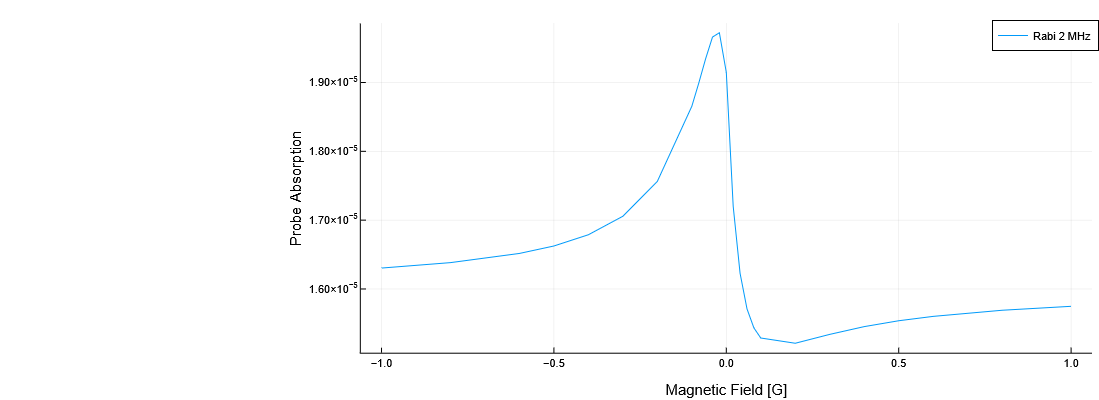

In [8]:
dfOmega2=DataFrame(B=xOmega2,Absorption=yOmega2)
CSV.write("CsD1_33_Omega2.csv",dfOmega2)
plot(xOmega2,yOmega2,xlabel="Magnetic Field [G]",ylabel="Probe Absorption",label="Rabi 2 MHz")

In [9]:
laz = laser(Ωᵣ=1.0)  # 3-->3 transition
println("Laser frequecy: ",laz.ω_bar," MHz")
println("Rabi frequecy: ",laz.Ωᵣ," MHz")

resOmega1=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(resOmega1,result)
end

xOmega1=Brange
myResults=reshape(resOmega1,(4,25))
yOmega1=myResults[2,:] |> real;

Laser frequecy: 3.351205628e8 MHz
Rabi frequecy: 1.0 + 0.0im MHz
Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


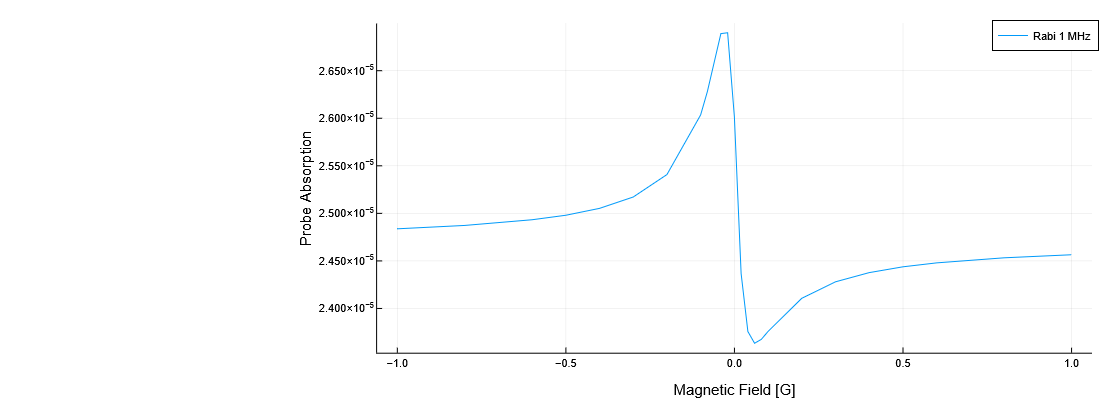

In [10]:
dfOmega1=DataFrame(B=xOmega1,Absorption=yOmega1)
CSV.write("CsD1_33_Omega1.csv",dfOmega2)
plot(xOmega1,yOmega1,xlabel="Magnetic Field [G]",ylabel="Probe Absorption",label="Rabi 1 MHz")

In [11]:
laz = laser(Ωᵣ=0.5)  # 3-->3 transition
println("Laser frequecy: ",laz.ω_bar," MHz")
println("Rabi frequecy: ",laz.Ωᵣ," MHz")

resOmega0k5=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(resOmega0k5,result)
end

xOmega0k5=Brange
myResults=reshape(resOmega0k5,(4,25))
yOmega0k5=myResults[2,:] |> real;

Laser frequecy: 3.351205628e8 MHz
Rabi frequecy: 0.5 + 0.0im MHz
Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


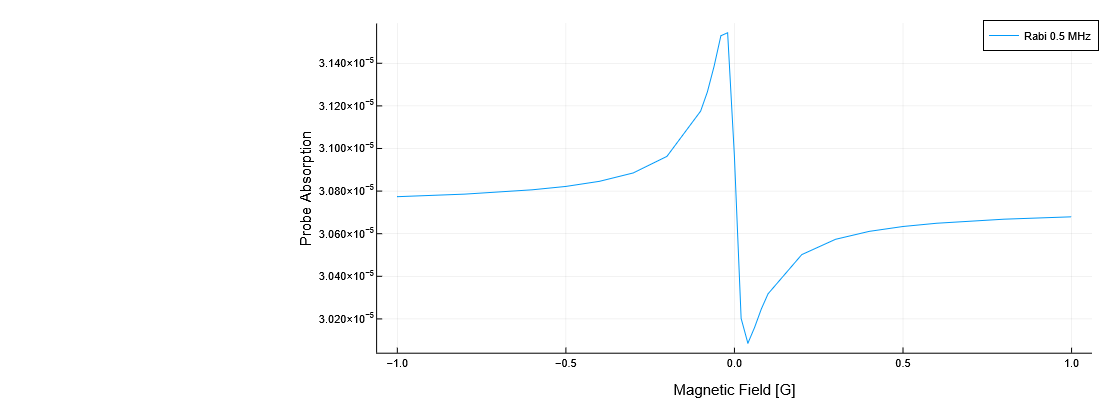

In [12]:
dfOmega0k5=DataFrame(B=xOmega0k5,Absorption=yOmega0k5)
CSV.write("CsD1_33_Omega0k5.csv",dfOmega2)
plot(xOmega0k5,yOmega0k5,xlabel="Magnetic Field [G]",ylabel="Probe Absorption",label="Rabi 0.5 MHz")

In [13]:
laz = laser(Ωᵣ=0.1)  # 3-->3 transition
println("Laser frequecy: ",laz.ω_bar," MHz")
println("Rabi frequecy: ",laz.Ωᵣ," MHz")

resOmega0k1=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(resOmega0k1,result)
end

xOmega0k1=Brange
myResults=reshape(resOmega0k1,(4,25))
yOmega0k1=myResults[2,:] |> real;

Laser frequecy: 3.351205628e8 MHz
Rabi frequecy: 0.1 + 0.0im MHz
Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


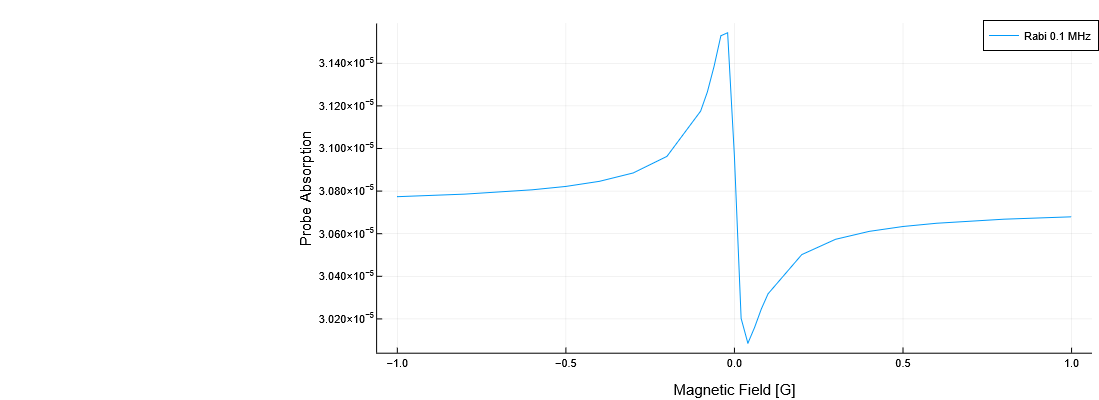

In [14]:
dfOmega0k1=DataFrame(B=xOmega0k1,Absorption=yOmega0k1)
CSV.write("CsD1_33_Omega0k1.csv",dfOmega2)
plot(xOmega0k5,yOmega0k5,xlabel="Magnetic Field [G]",ylabel="Probe Absorption",label="Rabi 0.1 MHz")

## Comparison
Having calculated and plotted the absorption separately for each transition, we can now normalize them and plot them on one graph. 

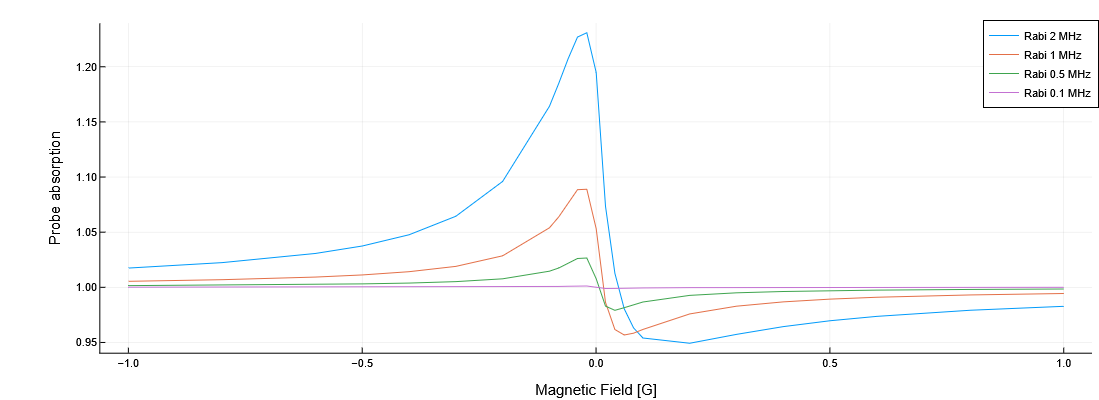

In [29]:
yOmega2norm=yOmega2./((yOmega2[begin]+yOmega2[end])/2.0)
yOmega1norm=yOmega1./((yOmega1[begin]+yOmega1[end])/2.0)
yOmega0k5norm=yOmega0k5./((yOmega0k5[begin]+yOmega0k5[end])/2.0)
yOmega0k1norm=yOmega0k1./((yOmega0k1[begin]+yOmega0k1[end])/2.0)
plot([xOmega2 xOmega1 xOmega0k5 xOmega0k1], [yOmega2norm yOmega1norm yOmega0k5norm yOmega0k1norm],xlabel="Magnetic Field [G]",ylabel="Probe absorption",label=["Rabi 2 MHz" "Rabi 1 MHz" "Rabi 0.5 MHz" "Rabi 0.1 MHz"])